In [2]:
# ! pip install langflow
# For installing langflow it took 145 minutes, Use the existing environment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 8.8 MB/s eta 0:00:00-:--:--
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 28.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 35.7 MB/s eta 0:00:00
  Installing build dependencies ... -^C
anceled


In [1]:
# ! pip install pandas pyodbc openpyxl

  Using cached numpy-2.2.2-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 25.0 MB/s eta 0:00:0000:010:01
Using cached numpy-2.2.2-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.1 MB)


In [1]:
# ! pip install vanna[chromadb,openai]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 15.8 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached distro-1.9.0-py3-none-any.whl.metadata (6.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 32.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 34.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 29.3 MB/s eta 0:00:00
Using cached distro-1.9.0-py3-none-any.whl (20 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.6/615.6 k

In [1]:
from vanna.openai import OpenAI_Chat
from vanna.chromadb import ChromaDB_VectorStore


In [2]:
openai_api = ''

In [3]:
class MyVanna(ChromaDB_VectorStore, OpenAI_Chat):
    def __init__(self, config=None):
        ChromaDB_VectorStore.__init__(self, config=config)
        OpenAI_Chat.__init__(self, config=config)

vn = MyVanna(config={'api_key': openai_api, 'model': 'gpt-4o'})

In [8]:
import pandas as pd
import sqlite3

# Read the CSV file and parse dates
csv_file = 'QRM_Utility_2m.csv'
df = pd.read_csv(csv_file, parse_dates=True)

# Infer data types
data_types = df.dtypes

# Create SQLite database and table
conn = sqlite3.connect('QRM.db')
cursor = conn.cursor()

# Define a function to map pandas data types to SQLite data types
def map_dtype(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INTEGER'
    elif pd.api.types.is_float_dtype(dtype):
        return 'REAL'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'TEXT'  # SQLite does not have a dedicated date type, use TEXT
    else:
        return 'TEXT'

# Create table schema with quoted column names
table_name = 'utility'
columns = ', '.join([f'"{col}" {map_dtype(dtype)}' for col, dtype in data_types.items()])
create_table_query = f'CREATE TABLE IF NOT EXISTS {table_name} ({columns})'
cursor.execute(create_table_query)

# Insert data into the table
df.to_sql(table_name, conn, if_exists='replace', index=False)

# Commit and close the connection
conn.commit()
conn.close()

print("Data has been successfully imported into the SQLite database")

Data has been successfully imported into the SQLite database


In [9]:
vn.connect_to_sqlite('QRM.db')

In [10]:
# [
#   {
#     "role": "system",
#     "content": "You are a SQLite expert. Please help to generate a SQL query to answer the question. \
#     Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \
#     ===Response Guidelines\n \
#     1. If the provided context is sufficient, please generate a valid SQL query without any explanations for the question.\n \
#     2. If the provided context is almost sufficient but requires knowledge of a specific string in a particular column, please generate an intermediate SQL query to find the distinct strings in that column. \
#     Prepend the query with a comment saying intermediate_sql\n \
#     3. If the provided context is insufficient, please explain why it can't be generated.\n \
#     4. Please use the most relevant table(s).\n \
#     5. If the question has been asked and answered before, please repeat the answer exactly as it was given before.\n \
#     6. Ensure that the output SQL is SQLite-compliant and executable, and free of syntax errors.\n"
#   },
#   {
#     "role": "user",
#     "content": "What is the total sales for the year 2019?"
#   }
# ]

### Training model

In [11]:
df_ddl = vn.run_sql("SELECT type, sql FROM sqlite_master WHERE sql is not null")

for ddl in df_ddl['sql'].to_list():
  vn.train(ddl=ddl)

Adding ddl: CREATE TABLE "QRM" (
"Month-Year" TEXT,
  "Product" TEXT,
  "Utility" TEXT,
  "Particulars" TEXT,
  "UOM" TEXT,
  "Bplan" REAL,
  "Target" REAL,
  "Actual" REAL,
  "Bplan  Var %" REAL,
  "Target  Var %" REAL,
  "Location" TEXT
)
Adding ddl: CREATE TABLE "utility" (
"Month-Year" TEXT,
  "Product" TEXT,
  "Utility" TEXT,
  "Particulars" TEXT,
  "UOM" TEXT,
  "Bplan" REAL,
  "Target" REAL,
  "Actual" REAL,
  "Bplan  Var %" REAL,
  "Target  Var %" REAL,
  "Location" TEXT
)


In [ ]:
# Sometimes you may want to add documentation about your business terminology or definitions.
vn.train(documentation="The 'Utility' table contains the Utility for QRM data.")


In [14]:
# At any time you can inspect what training data the package is able to reference
training_data = vn.get_training_data()
training_data

,id,question,content,training_data_type
0,b813e6f2-54f1-51b6-bbaa-f8354afe03b6-sql,What is the overall production efficiency by d...,"SELECT Product, Department, \n AVG(""Actu...",sql
1,f4e78a07-03a8-5a01-9a3a-eeb0792bf860-sql,What is the overall production efficiency by d...,"SELECT Product, Department, \n AVG(""Actu...",sql
2,0be64759-d8c6-5597-8096-7f81e4a1ce28-sql,Which products or departments have the highest...,"SELECT Product, Department, ""Business plan va...",sql
3,ef93f882-279a-5cf9-9c35-483f66b67c85-sql,How does actual production compare to the targ...,"SELECT Department, \n SUM(""Actual Produc...",sql
4,bbd38943-0100-5936-95a2-b30c84a5f039-sql,Which products or departments show the highest...,"SELECT Product, Department, ""FI as Per Busines...",sql
5,8b734392-3d3b-5ca5-a3f1-d11794d6b07c-sql,How does financial performance correlate with ...,"SELECT Month, AVG(CAST(REPLACE(""Business plan ...",sql
6,97fa5b28-01dd-53c0-98ac-471091a0987b-sql,How do business plan variations trend over tim...,"SELECT Department, \n AVG(CAST(REPLACE(""...",sql
7,e946a7c8-7a8e-5ee4-b20a-6d2507912fd2-sql,Are there recurring trends in production effic...,"SELECT Product, Department, ""Actual Produced (...",sql
8,7284733c-0ee6-571f-9234-1aea9c3b20b5-sql,Which locations have the most consistent produ...,"SELECT Location,\n AVG(""Actual Produced ...",sql
9,64493aac-5899-570e-b6dc-70e13a47e0b9-sql,How does production performance differ between...,"SELECT Location, \n SUM(""Actual Produced...",sql


In [14]:
# # You can remove training data if there's obsolete/incorrect information. 
# vn.remove_training_data(id='1-ddl')


Number of requested results 10 is greater than number of elements in index 3, updating n_results = 3
Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2


SQL Prompt: [{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "utility" (\n"Month-Year" TEXT,\n  "Product" TEXT,\n  "Utility" TEXT,\n  "Particulars" TEXT,\n  "UOM" TEXT,\n  "Bplan" REAL,\n  "Target" REAL,\n  "Actual" REAL,\n  "Bplan  Var %" REAL,\n  "Target  Var %" REAL,\n  "Location" TEXT\n)\n\nCREATE TABLE "QRM" (\n"Month-Year" TEXT,\n  "Product" TEXT,\n  "Utility" TEXT,\n  "Particulars" TEXT,\n  "UOM" TEXT,\n  "Bplan" REAL,\n  "Target" REAL,\n  "Actual" REAL,\n  "Bplan  Var %" REAL,\n  "Target  Var %" REAL,\n  "Location" TEXT\n)\n\nCREATE TABLE "QRM" (\n"Product" TEXT,\n  "Department" TEXT,\n  "Particulars" TEXT,\n  "Business plan (Metric Ton)" REAL,\n  "Target (Metric Ton)" REAL,\n  "Actual Produced (Metric Ton)" REAL,\n  "Business plan  variation %" TEXT,\n  "Target  Variati

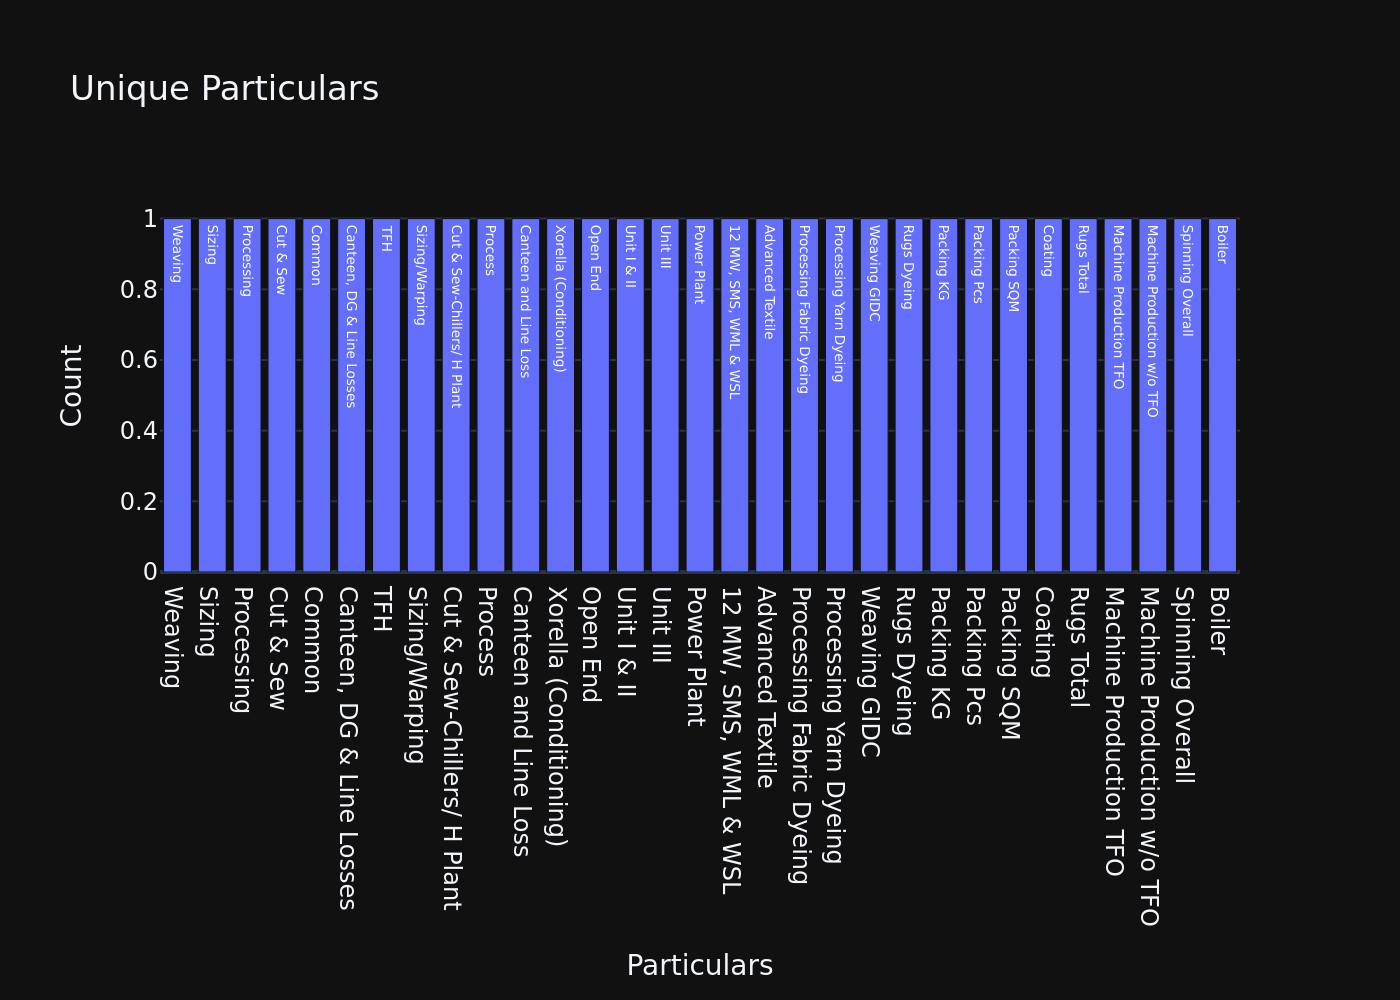

('SELECT DISTINCT Particulars\nFROM utility;',
                     Particulars
 0                       Weaving
 1                        Sizing
 2                    Processing
 3                     Cut & Sew
 4                        Common
 5     Canteen, DG & Line Losses
 6                           TFH
 7                Sizing/Warping
 8   Cut & Sew-Chillers/ H Plant
 9                       Process
 10        Canteen and Line Loss
 11       Xorella (Conditioning)
 12                     Open End
 13                  Unit I & II
 14                     Unit III
 15                  Power Plant
 16        12 MW, SMS, WML & WSL
 17             Advanced Textile
 18     Processing Fabric Dyeing
 19       Processing Yarn Dyeing
 20                 Weaving GIDC
 21                  Rugs Dyeing
 22                   Packing KG
 23                  Packing Pcs
 24                  Packing SQM
 25                      Coating
 26                   Rugs Total
 27       Machine Production 

In [15]:
query_res = vn.ask('what are the different Particulars in the utility?')
query_res

In [16]:
from vanna.flask import VannaFlaskApp
app = VannaFlaskApp(vn)
app.run()

Your app is running at:
http://localhost:8084
 * Serving Flask app 'vanna.flask'
 * Debug mode: on


Number of requested results 10 is greater than number of elements in index 3, updating n_results = 3
Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2


Using model gpt-4o for 1287.25 tokens (approx)
Using model gpt-4o for 113.25 tokens (approx)


Number of requested results 10 is greater than number of elements in index 3, updating n_results = 3
Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2


Using model gpt-4o for 1221.25 tokens (approx)
Using model gpt-4o for 130.0 tokens (approx)


Number of requested results 10 is greater than number of elements in index 3, updating n_results = 3
Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2


Using model gpt-4o for 1250.25 tokens (approx)
